# Product Recognition on Store Shelves

Problem to be solved in this Project:
"Object detection techniques based on computer vision can be deployed in super market scenarios for the
creation of a system capable of recognizing products on store shelves.
Given the image of a store shelf, such a system should be able identify the different products present
therein and may be deployed, e.g. to help visually impaired costumers or to automate some common store
management tasks (e.g. detect low in stock or misplaced products)."

Solution by:\
Damian Atlaß Nr: 1900125838\
Bruno Schaffer Nr: 1900125561\

Both project members did an equal amount of work, as can be seen in this repository:\
https://github.com/DamianAtlass/ProductRecOnStoreShelves

# Installation
The necessary packages for this notebook to work can be imported in a python 3.12.7 virtual environment by executing
> pip install -r requirements.txt

in the terminal.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math
import os

These are some convenience function for plotting and loading data.

In [2]:
#convenience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

def rotate_tuple(point, angle_degrees):
    # Convert angle to radians
    angle_radians = math.radians(angle_degrees)

    # Extract the x and y coordinates
    x, y = point

    # Apply the rotation matrix
    x_rotated = x * math.cos(angle_radians) - y * math.sin(angle_radians)
    y_rotated = x * math.sin(angle_radians) + y * math.cos(angle_radians)

    return (x_rotated, y_rotated)

def is_point_in_rectangle(p, rect):

    def vector(a, b):
        return (b[0] - a[0], b[1] - a[1])

    def dot_product(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]

    def magnitude_squared(v):
        return v[0]**2 + v[1]**2

    # Unpack rectangle vertices
    A, B, C, D = rect

    # Compute vectors
    AB = vector(A, B)
    AD = vector(A, D)
    AP = vector(A, p)

    # Check if the point projects within both sides of the rectangle
    within_AB = 0 <= dot_product(AP, AB) <= magnitude_squared(AB)
    within_AD = 0 <= dot_product(AP, AD) <= magnitude_squared(AD)

    return within_AB and within_AD

#drawing functions
def plot_images(image_paths):

    images = [cv.imread(p) for p in image_paths]

    # Check if the list is empty
    if not images:
        raise ValueError("The list of images is empty.")

    # Find the maximum height among all images
    max_height = max(img.shape[0] for img in images)

    # Resize all images to have the same height
    resized_images = [
        cv.resize(img, (int(img.shape[1] * max_height / img.shape[0]), max_height))
        for img in images
    ]

    # Horizontally concatenate images
    concatenated_image = np.hstack(resized_images)
    print([os.path.split(p)[-1] for p in image_paths])
    plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))
    plt.title("models")
    plt.show()

def draw_good_and_bad_matches(scene, good, bad, kp_scene):
#draw excluded and included matches
        for o in bad:
            x,y = kp_scene[o.trainIdx].pt
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,0,255), 2)

        for o in good:
            x,y = kp_scene[o.trainIdx].pt  # Get match coordinates
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,255,0), 2)

        plt.imshow(cv.cvtColor(scene, cv.COLOR_BGR2RGB))
        plt.title("Good and bad (rejected) matches")
        plt.show()

def draw_matches(model, kp_model, scene, kp_scene, good):
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                        singlePointColor = None, # not draw keypoints only matching lines
                        flags = 2) # not draw keypoints only lines
    image = cv.drawMatches(model, kp_model, scene, kp_scene, good, None,**draw_params)
    plt.title("Matched keypoints")
    plt.imshow(image)
    plt.show()

def draw_barycenter_predictions(scene, barygrid_cell_width, barygrid_cell_height, barycenter_votes, dst_kp):

    for b, d in zip(barycenter_votes, dst_kp):
        d = [int(d.pt[0]), int(d.pt[1])]
        cv.circle(scene, d, 3, (0,255,0), 4)
        cv.circle(scene, b, 3, (255,0,0), 4)
        cv.line(scene, d, b, color=(0, 255, 0), thickness=2)

    height, width, _ = scene.shape
    num_vertical_lines = width // barygrid_cell_width
    num_horizontal_lines = height // barygrid_cell_height

    for i in range(1, num_vertical_lines):
        x = i * barygrid_cell_width
        cv.line(scene, (x, 0), (x, height), color=(0, 0, 255), thickness=2)

    for i in range(1, num_horizontal_lines+1):
        y = i * barygrid_cell_height
        cv.line(scene, (0, y), (width, y), color=(0, 0, 255), thickness=2)

    plt.imshow(cv.cvtColor(scene, cv.COLOR_BGR2RGB))
    plt.title("Features with their respective joining vectors (green), bins and votes (blue)")
    plt.show()

To simplify handling the detected products, we decidde to use define a class to wrapp them into a single data structure.

In [3]:
class Product:
  def __init__(self, position, width, height, cornerpoints):
    self.position = position
    self.width = width
    self.height = height
    self.cornerpoints = cornerpoints

def product_recognition(scene, models, result, boldness = 3, size = 3):
    scene_gray = cv.imread(get_path_scene(scene))
    for i in range(len(result)):
        product_results = result[i]
        if len(product_results) > 0 and product_results[0] is not None:
            print(f"Product {models[i]} - {len(product_results)} instance(s) found:")
            for j in range(len(product_results)):
                print("\tInstance {}: position: {}, width: {}px, height: {}px".format(j,
                                                                                      product_results[j].position,
                                                                                      product_results[j].width,
                                                                                      product_results[j].height) )
                cv.rectangle(scene_gray,
                             (product_results[j].position[0] - int(product_results[j].width/2),
                              product_results[j].position[1] - int(product_results[j].height/2)),
                             (product_results[j].position[0] + int(product_results[j].width/2),
                              product_results[j].position[1] + int(product_results[j].height/2)),
                             (0,255,0),3)

                #add square and add text
                means = np.mean(product_results[j].cornerpoints, axis=0)

                #place text nicely
                _, y = [a for a in means[0]]
                x = min([o[0][0] for o in product_results[j].cornerpoints])*0.7 + max([o[0][0] for o in product_results[j].cornerpoints])*0.3

                cv.putText(scene_gray, str(models[i]), (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)

    plt.imshow(cv.cvtColor(scene_gray, cv.COLOR_BGR2RGB))
    plt.show()

# Step A - Multiple Product Detection:


The Task of Step A:

"Develop an object detection system to identify single instance of products given: one reference image for
each item and a scene image. The system should be able to correctly identify all the product in the shelves
image. One way to solve this task could be the use of local invariant feature as explained in lab session 5."

As proposed in the task description, we will utilize local invariant features to match a reference model with a scene image. This approach involves detecting keypoints and descriptors using SIFT, then matching them using the k-nearest neighbors algorithm. To filter out incorrect matches, we apply Lowe’s ratio test, retaining only the best matches. Finally, the remaining matches are used to determine the location of the model in the scene.

## Step by Step
In this first example, we will only try to locate cereal box 0 in scene e1 for simplicity’s sake.

In [4]:
scene_path = get_path_scene("e1.png")
model_path = get_path_model(0)
plot_diagrams=False

if plot_diagrams:
    plot_images(model_path)

scene_gray = cv.imread(scene_path, cv.IMREAD_GRAYSCALE)
scene_to_draw_on = cv.imread(scene_path)
model_gray = cv.imread(model_path, cv.IMREAD_GRAYSCALE)

### SIFT (Scale Invariant Feature Transform)
In this step we use SIFT to determine both the Keypoint's and descriptors of both the model and the scene. Sift works by following a few steps;
1. Keypoint Detection: SIFT determines keypoint locations using the Difference of Gaussians (DoG) function. A potential keypoint is identified as a local extremum in both scale and space within the DoG representation.
2. Keypoint Refinement: The initial set of keypoints includes many unstable points, which need to be refined. To improve accuracy, Taylor series expansion is used to localize keypoints more precisely. Keypoints found along edges are often unstable, so another pruning step based on the eigenvalues of the Hessian is necessary. If the curvature ratio exceeds a certain threshold, the keypoint is discarded.
3. Orientation Assignment: To ensure invariance to image rotation, each keypoint is assigned a canonical orientation. The keypoint’s neighborhood is divided into an orientation histogram with 36 bins, each covering 10 degrees. The dominant gradient direction is selected as the keypoint’s orientation, and any additional peaks above 80% of the maximum are also considered.
4. Descriptor Computation: Once keypoints are detected, descriptors are computed based on the surrounding area. The local region around each keypoint is divided into a grid, typically forming a 4×4 array of orientation histograms, with each histogram having 8 orientation bins. This results in a feature vector of 128 dimensions, which represents the keypoint descriptor.

Source: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

Visualization of keypoints in model image:


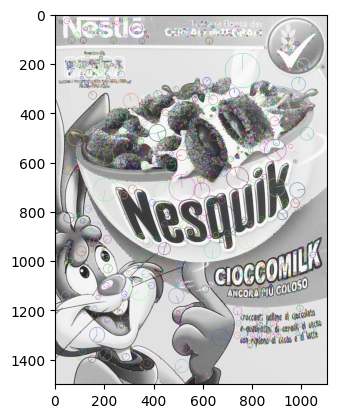

In [5]:
# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_model, des_model = sift.detectAndCompute(model_gray,None)
kp_scene, des_scene = sift.detectAndCompute(scene_gray,None)

img_visualization = cv.drawKeypoints(model_gray,kp_model,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print("Visualization of keypoints in model image:")
plt.imshow(img_visualization)
plt.show()

### Keypoint Matching
To match keypoints between the model and the scene, a nearest-neighbor algorithm is applied to the descriptors. However, a challenge arises when the difference between the best match and the second-best match is small, because this implies a low accuracy of the first match.

To reduce false matches, Lowe’s ratio test is used. This test computes the ratio between the best match and the second-best match. If the ratio is above a certain threshold, the match is rejected, as it suggests ambiguity. Lowe originally proposed a threshold of 0.8, but in our case, we use 0.7, as it was used in Lab Session 5.

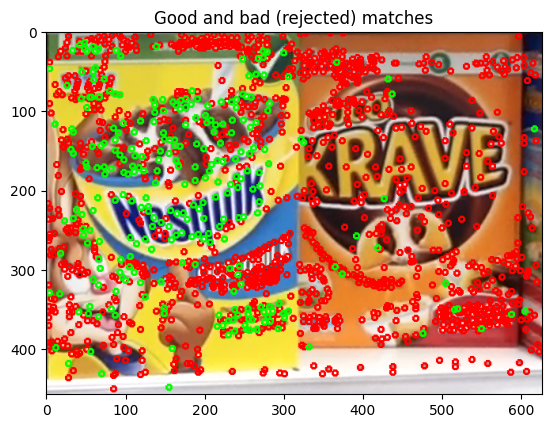

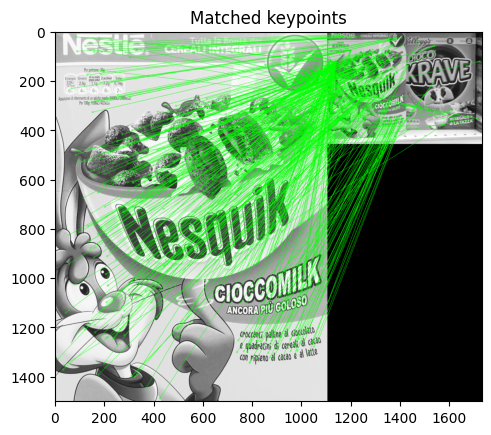

In [6]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_model,des_scene,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
bad = []
for m,n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
    else:
        bad.append(m)

draw_good_and_bad_matches(scene_to_draw_on, good, bad, kp_scene)
draw_matches(model_gray, kp_model, scene_gray, kp_scene, good)

### Homography and Perspective Transform
Once the model has been matched with the scene, the next step is to compute the homography, which describes how the model image has been scaled, rotated, and transformed in the scene.

The homography matrix can be derived from the matched keypoints. Using this transformation, OpenCV’s **cv2.perspectiveTransform()** function can be applied to find the coordinates of the four corner points of the model (e.g., a cereal box) in the scene.

During this process, it is important to note that just because a model produces a few matches, it does not necessarily mean it is present in the scene. To address this issue, a simple threshold on the minimum number of matches can be applied.

Setting an appropriate threshold can be challenging for large datasets, but in this case, where only a small number of models and scenes are considered, manually choosing a threshold is sufficient.

Enough matches are found - 471/200
------------------------------------------
Result:


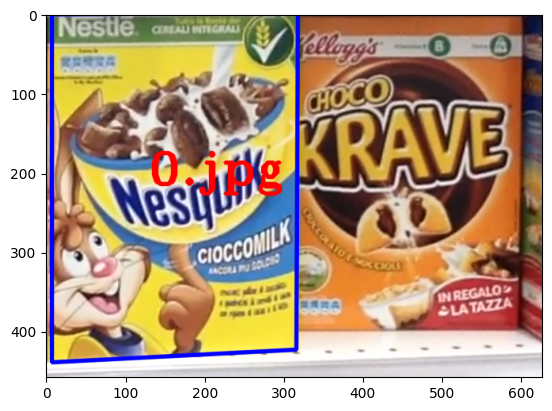

In [7]:
MIN_MATCH_COUNT = 200
scene_to_draw_on = cv.imread(scene_path)

if len(good)>MIN_MATCH_COUNT:
    print( "Enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    h,w = model_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    dst = cv.perspectiveTransform(pts,M)

    #add square and add text
    means = np.mean(dst, axis=0)
    x, y = [a for a in means[0]]
    x = x * 0.8 #adjust for text

    result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

    boldness = 3
    size = 3
    cv.putText(scene_to_draw_on, "0.jpg", (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )

print("------------------------------------------")
print("Result:")
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

## As Function
In the following section, all proposed steps will be bundled into a single function **find_image_A()**, which takes multiple models and a scene as input and returns the locations of the models in the scene. Additionally, all models are scaled to the same size, matching the smallest model, since we found that an  incorrect model with a high resolution could sometimes produce more matches than the correct model with a lower resolution.

The following code demonstrates that this approach successfully locates the model in simple scenes. However, as scene complexity increases (e.g., when two identical cereal boxes are present), the method begins to struggle. That’s why, in Step B, we will improve this approach by utilizing the Generalized Hough Transform.

In [8]:
def find_image_A(scene_path, model_paths, MIN_MATCH_COUNT = 200):
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    #create array with all models
    models = []
    for model_gray_path in model_paths:
        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    common_height = np.min([o["img"].shape[0] for o in models])

    results = []

    for model in models:
        model_gray = model["img"]
        ratio = common_height/model_gray.shape[0]
        new_w = model_gray.shape[1]*ratio
        model_gray = cv.resize(model_gray, (int(new_w), common_height), interpolation=cv.INTER_AREA)

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des_model = sift.detectAndCompute(model_gray,None)
        kp_scene, des_scene = sift.detectAndCompute(scene_gray,None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_model,des_scene,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        bad = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
            else:
                bad.append(m)

        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
            h,w = model_gray.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            
            dst = cv.perspectiveTransform(pts,M)

            # Compute height as the average of two height measurements
            height = int(((dst[1][0][1] - dst[0][0][1]) + (dst[2][0][1] - dst[3][0][1])) / 2)

            # Compute width as the average of two width measurements
            width = int(((dst[3][0][0] - dst[0][0][0]) + (dst[2][0][0] - dst[1][0][0])) / 2)

            # Compute center X coordinate
            x = int(((dst[3][0][0] - (dst[3][0][0] - dst[0][0][0]) / 2) +
                     (dst[2][0][0] - (dst[2][0][0] - dst[1][0][0]) / 2)) / 2)

            # Compute center Y coordinate
            y = int(((dst[1][0][1] - (dst[1][0][1] - dst[0][0][1]) / 2) +
                     (dst[2][0][1] - (dst[2][0][1] - dst[3][0][1]) / 2)) / 2)

            # Create product object and append to result list
            results.append([Product((x, y), width, height, dst)])
        else:
            results.append([None])
    return results

### Scene e1

Product 0 - 1 instance(s) found:
	Instance 0: position: (162, 214), width: 309px, height: 431px


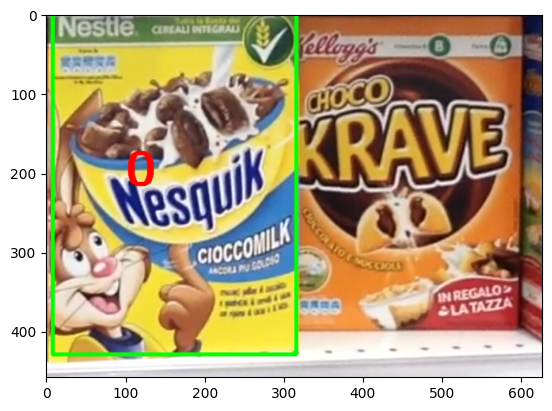

In [9]:
#define models to be searched in image
scene = "e1.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

### Scene e2

Product 24 - 1 instance(s) found:
	Instance 0: position: (166, 218), width: 334px, height: 489px
Product 26 - 1 instance(s) found:
	Instance 0: position: (538, 218), width: 332px, height: 485px


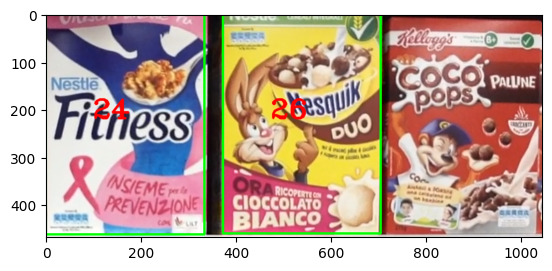

In [10]:
#define models to be searched in image
scene = "e2.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

### Scene e3

Product 0 - 1 instance(s) found:
	Instance 0: position: (170, 235), width: 323px, height: 438px


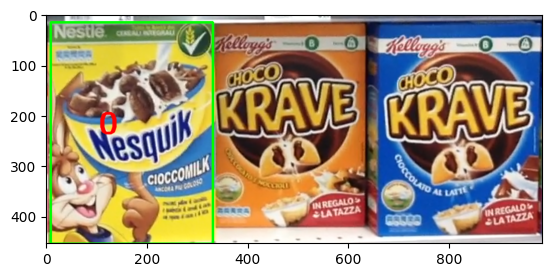

In [11]:
scene = "e3.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

### Scene e4

Product 0 - 1 instance(s) found:
	Instance 0: position: (158, 738), width: 323px, height: 438px
Product 26 - 1 instance(s) found:
	Instance 0: position: (205, 195), width: 340px, height: 493px


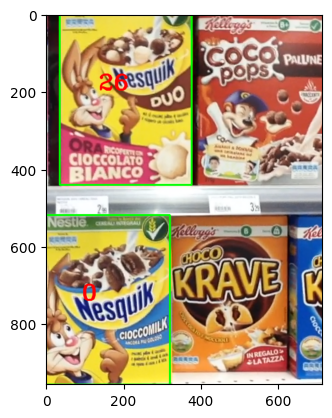

In [12]:
scene = "e4.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

### Scene e5

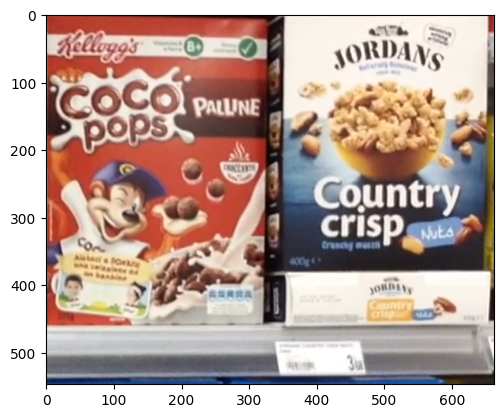

In [13]:
scene = "e5.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

# Step B - Multiple Instance Detection:

## Step by step

In the following cells, we are going to explain our code step by step on an example before defining and executing it all in one function.

The next cells defines our scene and model, as well as some parameters that are going to be important later.

In [14]:
#set parameters for demonstration
scene = "m1.png"
scene_path=get_path_scene(scene)
models = [0, 1, 11, 19, 24, 25, 26]

scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)
scene_color = cv.imread(scene_path) # for illustrative purposes
model_gray = cv.imread(get_path_model(24), cv.IMREAD_GRAYSCALE)


product_result = []

The Detection of keypoints and matching is the same process as in step A.

In [15]:
# we also make use of a percentage based threshold to handle feature rich images easier
MIN_MATCH_PERCENTAGE = 13
MIN_MATCH_COUNT = 300

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_model, des1 = sift.detectAndCompute(model_gray, None)
kp_scene, des2 = sift.detectAndCompute(scene_gray, None)

MIN_MATCH_PERCENTAGE_THRESHOLD = int(len(kp_model) * MIN_MATCH_PERCENTAGE / 100)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

src_kp = [kp_model[m.queryIdx] for m in good]
dst_kp = [kp_scene[m.trainIdx] for m in good]

In this subsection, we are going to make use of the Generalized Hough Transformation in combination with Local Invariant Features, which is also called _Star Model_. Instead of an R-table representing the edges of a shape, the GHT + SIFT uses not only the matched features, but also their position relative to a reference point (in this case: the object's barycenter). Those vectors describing the location relative the the barycenter are called _joining vectors_ and should technically all point to the same position (after a transformation is applied). Features which's joining vectors deviate a lot from the most the most common area might be missmatched and can therefore be discarded which improves the model detection. This _area_ is determent by a grid-based voting mechanism.

The barycenter P<sub>C</sub> is computed by taking the mean of all found features in the model:

P<sub>C</sub> = $\frac{1}{N}$ $\sum_{i=1}^N P_i$ , P being the position of the _i_ th feature.

The following code computes P<sub>C</sub> and stores the joining vectors in an array:

In [16]:
if len(good) >= MIN_MATCH_COUNT or len(good) >= MIN_MATCH_PERCENTAGE_THRESHOLD:
    # Compute the barycenter
    points = np.array([kp.pt for kp in src_kp], dtype=np.float32)
    barycenter = points.mean(axis=0).astype(int)

    # compute the joining vectors
    points = np.array([kp.pt for kp in src_kp], dtype=np.float32).astype(int)
    joining_vectors = barycenter - points

In this part of the code, for each feature found in the scene the barycenter of the object in the scene is predicted based on the model's joining vector. Because the object in the scene might be scaled and rotated we need to transform the joining vector $V_i$ based on the difference in scale $\Delta S_j$ and rotation $\Delta \varphi_j$ of the feature in the scene. The following formula describes the calculation of the (presumed) barycenter:

$\tilde{\mathbf{P}}_{C_j} = \tilde{\mathbf{P}}_j + \Delta S_j \cdot R(\Delta \varphi_j) \mathbf{V}_i$

In [17]:
if len(good)>=MIN_MATCH_COUNT or len(good)>=MIN_MATCH_PERCENTAGE_THRESHOLD:

    barycenter_votes = []

    for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

        jv_x, jv_y = jv

        pt_x, pt_y = d.pt
        delta_s = d.size/s.size

        delta_phi = d.angle - s.angle

        angle_radians = math.radians(delta_phi)
        jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
        jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

        bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
        barycenter_votes.append(bary_predict)

This cell implements the voting. The voting assumes that correctly matched features describe the barycenter at the same position. A 25x25px grid is laid over the image, seperating it in bins. For a feature to be considered its joining vector need to point to a bin with at least 25 votes. This number has proofed well in our testing. The figure shows all matches and where their joining vectors are pointing at. Also, for each winning bin an average of all predicted barycenters is saved in an array called _barygrid_means_ which will be relevant later.

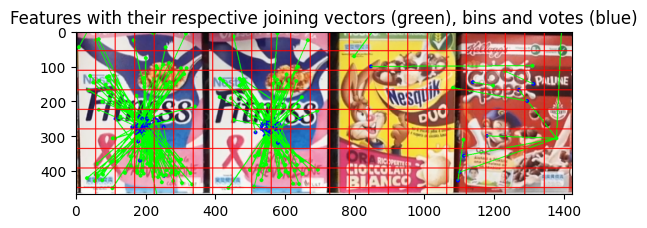

In [18]:
GRID_RESOLUTION=25
MIN_VOTES=25


x_cell = int(scene_gray.shape[1]/GRID_RESOLUTION)
y_cell = x_cell

y_cells_n = int(scene_gray.shape[1]//y_cell + 1)

# Initialize a 2D array where each element is an empty list
grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

barygrid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

# assign features matches and barycenters to grids
for i in range(0,len(barycenter_votes)):
    bary = barycenter_votes[i]
    # Check if predict Bary center is in Picture
    if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
        x_idx = int(bary[0]/x_cell)
        y_idx = int(bary[1]/y_cell)
        grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
        barygrid[x_idx][y_idx].append(bary)

draw_barycenter_predictions(scene_color.copy(), x_cell, y_cell, barycenter_votes, dst_kp)

# select vote winners in grid
barygrid_means = []
winners = []
for i in range(0,len(grid)):
    for j in range(0,len(grid[i])):
        if len(grid[i][j])>MIN_VOTES:
            winners.append(grid[i][j])
            barygrid_means.append(np.mean(barygrid[i][j], axis=0))

The upper part of the next cell makes use of _barygrid_means_, which contains the mean value of bins who won in the voting, by checking if it lies in an area which must be ignored. Ignored areas are those where an object of the same type has already been found. This is necessary, since a dense cloud of predicted barycenters could be cut in half during the voting depending on the placment of the grid. To prevent looking for the same object twice or thrice, as soon as on object was recognized, we prevent the code from looking for in again in the same area. Looking for the same instance in other places of the scene is still possible.

The lower part uses our filterd matched feature to calculate the the perspective transformation of the model, its homography, by using __cv.findHomography()__. We then use __cv.perspectiveTransform()__ to lay its corners on the scene to visualize it. Since the task suggests a need for the shapes to be rectangular, we adjust them for the wanted shape and add them to the list of results.

here


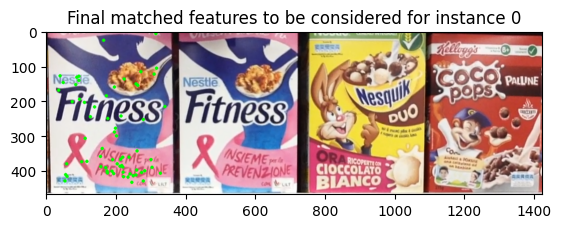

here


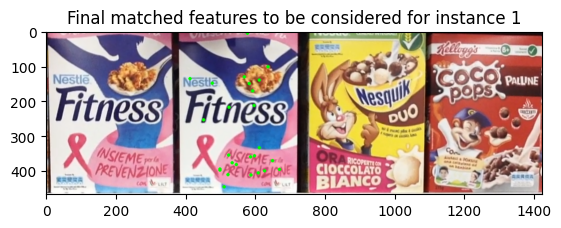

In [19]:
counter = 0

ignored_area = []
for winner, barygrid_mean in zip(winners, barygrid_means):


    # check if Winner is in area with already found winner
    winner_found = False
    for rec in ignored_area:
        if is_point_in_rectangle(barygrid_mean, rec):
            winner_found = True
            break

    if winner_found:
        continue

    print("here")
    #USE THIS TO DRAW THE RESULTS FROM POINTS
    src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)

    #draw the final matched features to be considered to calculate the homography with
    tmp = scene_color.copy()
    for coord in dst_pts:
        cv.circle(tmp, np.array([o for o in coord[0]], dtype=np.int64), 2, (0,255,0), 5)

    plt.imshow(cv.cvtColor(tmp, cv.COLOR_BGR2RGB))
    plt.title(f"Final matched features to be considered for instance {counter}")
    plt.show()

    counter+=1

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    h,w = model_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    dst = cv.perspectiveTransform(pts,M)

    # Compute height as the average of two height measurements
    height = int(((dst[1][0][1] - dst[0][0][1]) + (dst[2][0][1] - dst[3][0][1])) / 2)

    # Compute width as the average of two width measurements
    width = int(((dst[3][0][0] - dst[0][0][0]) + (dst[2][0][0] - dst[1][0][0])) / 2)

    # Compute center X coordinate
    x = int(((dst[3][0][0] - (dst[3][0][0] - dst[0][0][0]) / 2) +
                (dst[2][0][0] - (dst[2][0][0] - dst[1][0][0]) / 2)) / 2)

    # Compute center Y coordinate
    y = int(((dst[1][0][1] - (dst[1][0][1] - dst[0][0][1]) / 2) +
                (dst[2][0][1] - (dst[2][0][1] - dst[3][0][1]) / 2)) / 2)

    # Create product object and append to result list
    product_result.append(Product((x, y), width, height, dst))

    #add found instance to ignored areas
    ignored_area.append([o[0] for o in np.int32(dst)])


Product 24 - 2 instance(s) found:
	Instance 0: position: (184, 214), width: 350px, height: 499px
	Instance 1: position: (550, 219), width: 334px, height: 490px


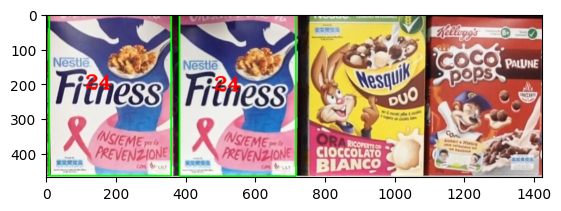

In [20]:
models = [24]
product_recognition(scene, models, [product_result])

## As Function

The following cell takes all of our previoursly discussed code snippets and merges them into one function **find_image_B()** taking into account to detecting multiple models.

In [21]:
def find_image_B(scene_path, model_paths, MIN_MATCH_PERCENTAGE = 13, MIN_MATCH_COUNT=300, GRID_RESOLUTION=25, MIN_VOTES=25):
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    result = []

    #create array with all models
    models = []
    for model_gray_path in model_paths:

        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        product_result = []

        # Apply model preprocessing
        model_gray = model["img"]

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des1 = sift.detectAndCompute(model_gray,None)
        kp_scene, des2 = sift.detectAndCompute(scene_gray,None)

        MIN_MATCH_PERCENTAGE_THRESHOLD = int(len(kp_model) * MIN_MATCH_PERCENTAGE/100)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        src_kp = [kp_model[m.queryIdx] for m in good]
        dst_kp = [kp_scene[m.trainIdx] for m in good]

        if len(good)>=MIN_MATCH_COUNT or len(good)>=MIN_MATCH_PERCENTAGE_THRESHOLD:
            #calculate barycenter of model
            x = 0
            y = 0
            for kp in src_kp:
                x_kp, y_kp = kp.pt
                x += x_kp
                y += y_kp
            barycenter = np.array([int(x/len(src_kp)), int(y/len(src_kp))])

            # calculate joining vectors of model
            joining_vectors = []
            for kp in src_kp:
                x, y = kp.pt
                v = barycenter - [int(x), int(y)]
                joining_vectors.append(v)

            barycenter_votes = []

            for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

                if jv is None:
                    raise Exception("there must be the same point in")

                jv_x, jv_y = jv

                pt_x, pt_y = d.pt
                delta_s = d.size/s.size

                delta_phi = d.angle - s.angle

                angle_radians = math.radians(delta_phi)
                jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
                jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

                bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
                barycenter_votes.append(bary_predict)

            x_cell = int(scene_gray.shape[1]/GRID_RESOLUTION)
            y_cell = x_cell

            y_cells_n = int(scene_gray.shape[1]//y_cell + 1)

            # Initialize a 2D array where each element is an empty list
            grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            barygrid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            # assign features matches and barycenters to grids
            for i in range(0,len(barycenter_votes)):
                bary = barycenter_votes[i]
                # Check if predict Bary center is in Picture
                if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
                    x_idx = int(bary[0]/x_cell)
                    y_idx = int(bary[1]/y_cell)
                    grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
                    barygrid[x_idx][y_idx].append(bary)
            # select vote winners in grid
            barygrid_means = []
            winners = []

            for i in range(0,len(grid)):
                for j in range(0,len(grid[i])):
                    if len(grid[i][j])>MIN_VOTES:
                        winners.append(grid[i][j])
                        barygrid_means.append(np.mean(barygrid[i][j], axis=0))

            ignored_area = []
            for winner, barygrid_mean in zip(winners, barygrid_means):

                # check if Winner is in area with already found winner
                winner_found = False
                for rec in ignored_area:
                    if is_point_in_rectangle(barygrid_mean, rec):
                        winner_found = True
                        break

                if winner_found:
                    continue
                #USE THIS TO DRAW THE RESULTS FROM POINTS
                src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)

                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
                h,w = model_gray.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

                dst = cv.perspectiveTransform(pts,M)

                # Compute height as the average of two height measurements
                height = int(((dst[1][0][1] - dst[0][0][1]) + (dst[2][0][1] - dst[3][0][1])) / 2)

                # Compute width as the average of two width measurements
                width = int(((dst[3][0][0] - dst[0][0][0]) + (dst[2][0][0] - dst[1][0][0])) / 2)

                # Compute center X coordinate
                x = int(((dst[3][0][0] - (dst[3][0][0] - dst[0][0][0]) / 2) +
                         (dst[2][0][0] - (dst[2][0][0] - dst[1][0][0]) / 2)) / 2)

                # Compute center Y coordinate
                y = int(((dst[1][0][1] - (dst[1][0][1] - dst[0][0][1]) / 2) +
                         (dst[2][0][1] - (dst[2][0][1] - dst[3][0][1]) / 2)) / 2)

                # Create product object and append to result list
                product_result.append(Product((x, y), width, height, dst))

                #add found instance to ignored areas
                ignored_area.append([o[0] for o in np.int32(dst)])
        result.append(product_result)
    return result

Product 24 - 2 instance(s) found:
	Instance 0: position: (184, 214), width: 351px, height: 500px
	Instance 1: position: (550, 219), width: 336px, height: 490px
Product 26 - 1 instance(s) found:
	Instance 0: position: (921, 218), width: 333px, height: 486px


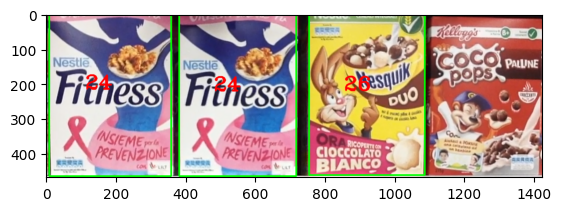

In [22]:
#define models to be searched in image
scene = "m1.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

Product 0 - 1 instance(s) found:
	Instance 0: position: (179, 300), width: 343px, height: 448px


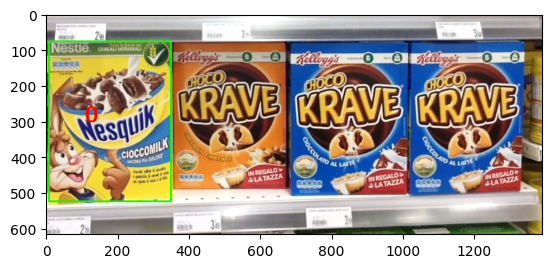

In [23]:
#define models to be searched in image
scene = "m2.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

Product 19 - 1 instance(s) found:
	Instance 0: position: (1233, 189), width: 295px, height: 382px
Product 26 - 1 instance(s) found:
	Instance 0: position: (195, 206), width: 354px, height: 506px


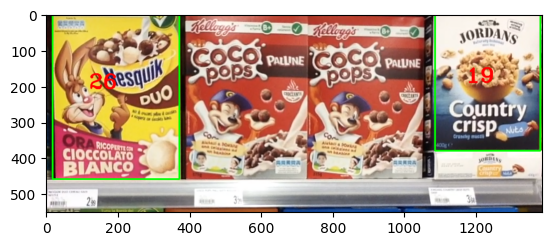

In [24]:
#define models to be searched in image
scene = "m3.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

Product 24 - 2 instance(s) found:
	Instance 0: position: (161, 191), width: 363px, height: 508px
	Instance 1: position: (540, 196), width: 348px, height: 499px
Product 26 - 1 instance(s) found:
	Instance 0: position: (921, 195), width: 340px, height: 493px


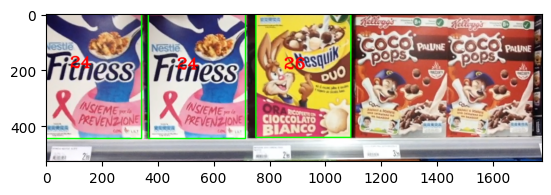

In [25]:
#define models to be searched in image
scene = "m4.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

Product 19 - 1 instance(s) found:
	Instance 0: position: (908, 190), width: 295px, height: 384px


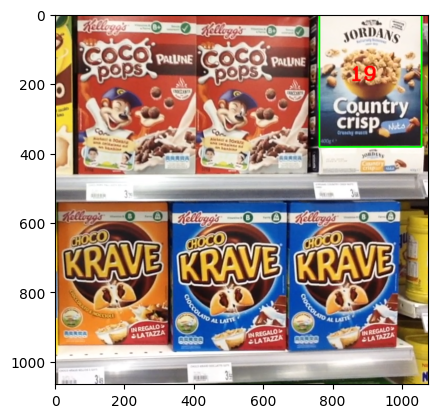

In [26]:
#define models to be searched in image
scene = "m5.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

# Step C - Whole shelve challenge:

Step C runs on the same code as Step B does, but we refiened the parameters even more to work for the more challenging scenes. We successfully recognized some of the products but recognizing all was not possible, partly because the number of features detected in the scenes were very low for each product, because the scene's resolution were relativly bad.
Since we could not find a dataset containing cereal boxes, machine learning / deep learning approaches were also not possible.

Product 0 - 1 instance(s) found:
	Instance 0: position: (279, 309), width: 56px, height: 72px
Product 1 - 1 instance(s) found:
	Instance 0: position: (455, 313), width: 58px, height: 73px
Product 2 - 2 instance(s) found:
	Instance 0: position: (36, 108), width: 62px, height: 92px
	Instance 1: position: (105, 109), width: 58px, height: 91px
Product 3 - 2 instance(s) found:
	Instance 0: position: (199, 460), width: 203px, height: 155px
	Instance 1: position: (334, 409), width: 62px, height: 84px
Product 4 - 1 instance(s) found:
	Instance 0: position: (163, 107), width: 74px, height: 100px
Product 11 - 1 instance(s) found:
	Instance 0: position: (456, 314), width: 59px, height: 73px
Product 14 - 1 instance(s) found:
	Instance 0: position: (485, 362), width: -39px, height: -53px
Product 15 - 1 instance(s) found:
	Instance 0: position: (511, 416), width: 57px, height: 65px
Product 18 - 1 instance(s) found:
	Instance 0: position: (547, 216), width: 58px, height: 69px
Product 19 - 1 instance(

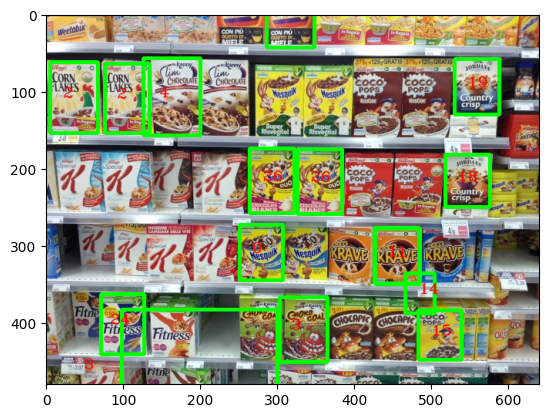

In [27]:
#define models to be searched in image
scene = "h1.jpg"
models = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                      model_paths=[get_path_model(a) for a in models],
                      MIN_MATCH_COUNT = 5,
                      GRID_RESOLUTION = 50,
                      MIN_VOTES=5)

product_recognition(scene, models, result, boldness = 1, size = 1)

Product 0 - 2 instance(s) found:
	Instance 0: position: (255, 325), width: 61px, height: 72px
	Instance 1: position: (312, 328), width: 56px, height: 72px
Product 1 - 1 instance(s) found:
	Instance 0: position: (366, 326), width: 55px, height: 71px
Product 7 - 1 instance(s) found:
	Instance 0: position: (393, 128), width: 56px, height: 89px
Product 15 - 1 instance(s) found:
	Instance 0: position: (511, 428), width: 55px, height: 63px
Product 19 - 1 instance(s) found:
	Instance 0: position: (533, 133), width: 56px, height: 70px
Product 22 - 2 instance(s) found:
	Instance 0: position: (223, 16), width: 64px, height: 97px
	Instance 1: position: (289, 17), width: 62px, height: 96px
Product 26 - 2 instance(s) found:
	Instance 0: position: (246, 237), width: 59px, height: 83px
	Instance 1: position: (314, 236), width: 58px, height: 81px


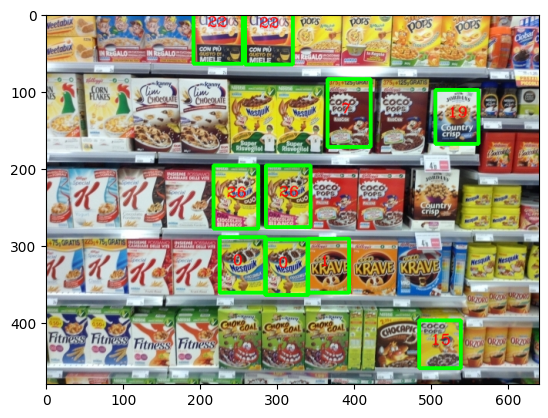

In [28]:
#define models to be searched in image
scene = "h2.jpg"
models = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                      model_paths=[get_path_model(a) for a in models],
                      MIN_MATCH_COUNT = 5,
                      GRID_RESOLUTION = 50,
                      MIN_VOTES=5)

product_recognition(scene, models, result, boldness = 1, size = 1)

Product 0 - 2 instance(s) found:
	Instance 0: position: (347, 309), width: 54px, height: 70px
	Instance 1: position: (405, 311), width: 55px, height: 71px
Product 1 - 1 instance(s) found:
	Instance 0: position: (462, 316), width: 56px, height: 68px
Product 3 - 1 instance(s) found:
	Instance 0: position: (456, 409), width: 59px, height: 78px
Product 4 - 2 instance(s) found:
	Instance 0: position: (244, 121), width: 62px, height: 90px
	Instance 1: position: (302, 120), width: 62px, height: 92px
Product 11 - 1 instance(s) found:
	Instance 0: position: (523, 317), width: 60px, height: 72px
Product 14 - 1 instance(s) found:
	Instance 0: position: (554, 412), width: 56px, height: 76px
Product 15 - 1 instance(s) found:
	Instance 0: position: (615, 419), width: 60px, height: 66px
Product 16 - 1 instance(s) found:
	Instance 0: position: (584, -3), width: 65px, height: 95px
Product 18 - 1 instance(s) found:
	Instance 0: position: (614, 218), width: 59px, height: 68px
Product 26 - 1 instance(s) f

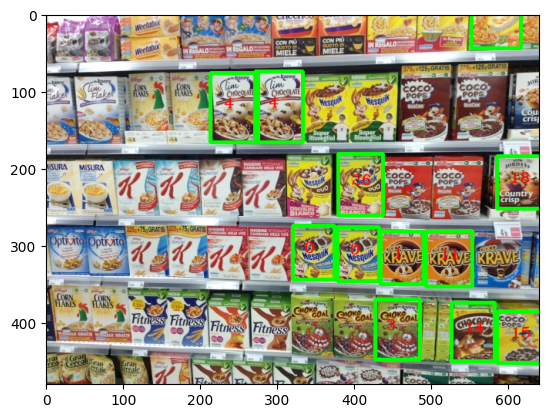

In [29]:
#define models to be searched in image
scene = "h3.jpg"
models = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                      model_paths=[get_path_model(a) for a in models],
                      MIN_MATCH_COUNT = 5,
                      GRID_RESOLUTION = 50,
                      MIN_VOTES=5)

product_recognition(scene, models, result, boldness = 1, size = 1)

Product 0 - 1 instance(s) found:
	Instance 0: position: (327, 337), width: 59px, height: 77px
Product 1 - 2 instance(s) found:
	Instance 0: position: (388, 334), width: 58px, height: 76px
	Instance 1: position: (446, 339), width: 57px, height: 72px
Product 2 - 1 instance(s) found:
	Instance 0: position: (85, 130), width: 64px, height: 96px
Product 3 - 2 instance(s) found:
	Instance 0: position: (260, 451), width: 67px, height: 66px
	Instance 1: position: (326, 441), width: 65px, height: 88px
Product 4 - 1 instance(s) found:
	Instance 0: position: (150, 129), width: 72px, height: 102px
Product 7 - 2 instance(s) found:
	Instance 0: position: (390, 245), width: 55px, height: 92px
	Instance 1: position: (420, 128), width: 60px, height: 97px
Product 11 - 1 instance(s) found:
	Instance 0: position: (447, 337), width: 59px, height: 74px
Product 12 - 1 instance(s) found:
	Instance 0: position: (207, 450), width: 65px, height: 80px
Product 14 - 1 instance(s) found:
	Instance 0: position: (387, 

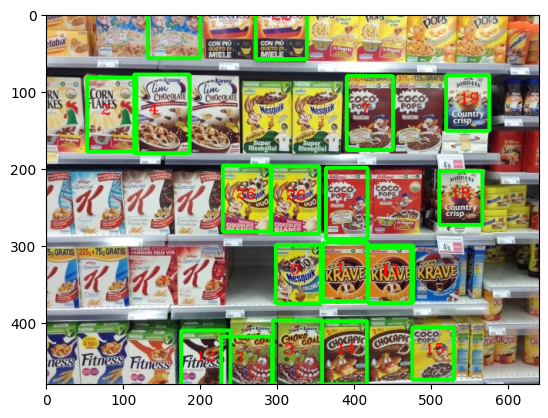

In [30]:
#define models to be searched in image
scene = "h4.jpg"
models = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                      model_paths=[get_path_model(a) for a in models],
                      MIN_MATCH_COUNT = 5,
                      GRID_RESOLUTION = 50,
                      MIN_VOTES=5)

product_recognition(scene, models, result, boldness = 1, size = 1)

Product 0 - 2 instance(s) found:
	Instance 0: position: (222, 344), width: 63px, height: 77px
	Instance 1: position: (283, 337), width: 57px, height: 73px
Product 1 - 1 instance(s) found:
	Instance 0: position: (351, 354), width: 68px, height: 76px
Product 3 - 1 instance(s) found:
	Instance 0: position: (274, 443), width: 65px, height: 83px
Product 4 - 2 instance(s) found:
	Instance 0: position: (99, 135), width: 70px, height: 101px
	Instance 1: position: (165, 137), width: 73px, height: 100px
Product 14 - 1 instance(s) found:
	Instance 0: position: (435, 428), width: 54px, height: 76px
Product 15 - 1 instance(s) found:
	Instance 0: position: (492, 437), width: 57px, height: 64px
Product 18 - 2 instance(s) found:
	Instance 0: position: (484, 245), width: 59px, height: 70px
	Instance 1: position: (519, 136), width: 62px, height: 76px
Product 19 - 1 instance(s) found:
	Instance 0: position: (519, 136), width: 62px, height: 75px
Product 22 - 2 instance(s) found:
	Instance 0: position: (18

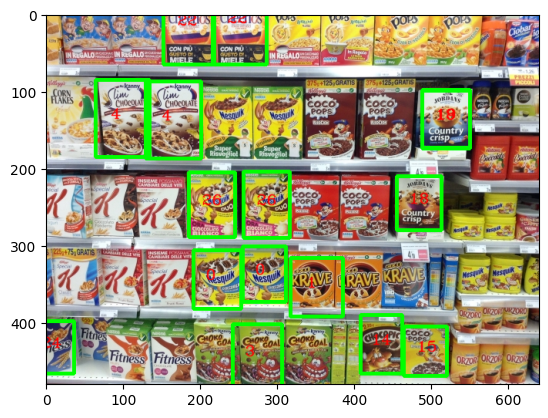

In [31]:
#define models to be searched in image
scene = "h5.jpg"
models = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

result = find_image_B(scene_path=get_path_scene(scene),
                      model_paths=[get_path_model(a) for a in models],
                      MIN_MATCH_COUNT = 5,
                      GRID_RESOLUTION = 50,
                      MIN_VOTES=5)

product_recognition(scene, models, result, boldness = 1, size = 1)

# Source
https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html